# Percentage of Bachelor’s degrees conferred to women in the U.S., by major

This notebook provides the methodology and code used in the blog post, [Percentage of Bachelor’s degrees conferred to women in the U.S., by major (1970-2014)](http://www.randalolson.com/2014/06/14/percentage-of-bachelors-degrees-conferred-to-women-by-major-1970-2012/).

### Notebook by [Randal S. Olson](http://www.randalolson.com)

Please see the [repository README file](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects#license) for the licenses and usage terms for the instructional material and code in this notebook. In general, I have licensed this material so that it is as widely useable and shareable as possible.

### Required Python libraries

If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This code uses base Python libraries except for the `BeautifulSoup`, `pandas`, and `matplotlib` packages. You can install these packages using `pip` by typing the following command into your command line:

> pip install beautifulsoup4 pandas matplotlib 

If you're on a Mac, Linux, or Unix machine, you may need to type `sudo` before the command to install the package with administrator privileges.

### Scraping the NCES database

To acquire the data used in the blog post, we need to scrape the [NCES database](http://nces.ed.gov/programs/digest/current_tables.asp). The NCES database is available for download as Excel files, but we didn't want to deal with a bunch of Excel files. Instead, let's scrape the NCES database web pages directly using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/).

Running the code below will create a file called `gender_degree_data.tsv` that contains all data about the gender breakdowns of various degree majors in the US.

In [1]:
from bs4 import BeautifulSoup
import requests

with open('gender_degree_data.tsv', 'w') as out_file:

    out_file.write('\t'.join(['Year', 'Degree_Major',
                          'Total_Bachelors',
                          'Percent_change_Bachelors',
                          'Male_Bachelors', 'Female_Bachelors', 'Female_percent_Bachelors',
                          'Total_Masters', 'Male_Masters', 'Female_Masters',
                          'Total_Doctorates', 'Male_Doctorates', 'Female_Doctorates']) + '\n')

    table_list_response = requests.get('http://nces.ed.gov/programs/digest/current_tables.asp')
    table_list_response = BeautifulSoup(table_list_response.text, 'lxml')

    for link in table_list_response.find_all('a', href=True):
        # We only want the tables that stratify the data by degree and gender, which are in table group 325
        if 'dt15_325' in link['href'] and int(link.text.split('.')[1]) % 5 == 0:
            url = 'http://nces.ed.gov/programs/digest/{}'.format(link['href'])
            url_response = requests.get(url)
            url_response = BeautifulSoup(url_response.text, 'lxml')
            degree_major = url_response.find('title').text.split('Degrees in')[1].split('conferred')[0].strip()

            all_trs = url_response.find_all('tr')
            for tr in all_trs:
                # We only want to parse entries that correspond to a certain year
                year_header = tr.find('th')
                if year_header is None:
                    continue

                # Stop parsing after all of the years are listed
                if 'Percent change' in year_header.text:
                    break

                # Years always have a dash (-) in them
                if '-' not in year_header.text:
                    continue

                year = str(int(year_header.text.split('-')[0]) + 1)
                year_vals = [x.text.replace(',', '').replace('†', '0').replace('#', '0') for x in tr.find_all('td')]

                out_text = '\t'.join([year, degree_major] + year_vals) + '\n'
                out_file.write(out_text)

### Visualizing the gender breakdowns for the various degree programs

Next, let's use [matplotlib](http://matplotlib.org) to visualize the trends in the gender breakdowns.

/Users/randal_olson/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/randal_olson/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


''

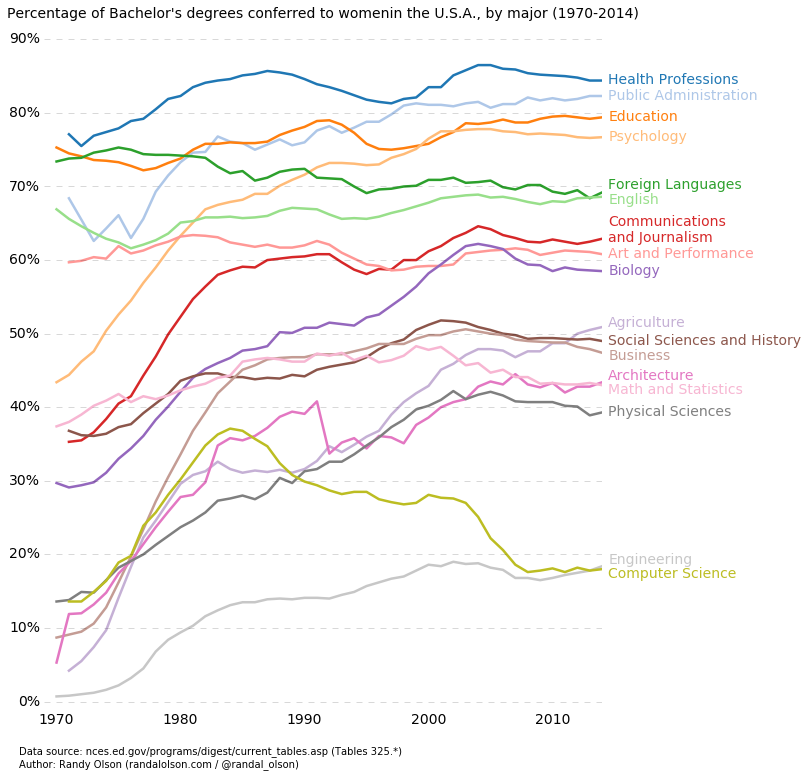

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# This is my custom style that does most of the plot formatting
plt.style.use('https://gist.githubusercontent.com/rhiever/a4fb39bfab4b33af0018/raw/b25b4ba478c2e163dd54fd5600e80ca7453459da/tableau20.mplstyle')

degree_gender_data = pd.read_csv('gender_degree_data.tsv', sep='\t')
degree_gender_data = degree_gender_data[degree_gender_data['Year'] >= 1970]
degree_gender_data.set_index('Year', inplace=True)

# Create a list of the degree majors ranked by their last value in the time series
# We'll use this list to determine what colors the degree majors are assigned
degree_major_order = degree_gender_data.groupby('Degree_Major')['Female_percent_Bachelors'].last()
degree_major_order = degree_major_order.sort_values(ascending=False).index.values
degree_major_order_dict = dict(zip(degree_major_order, range(len(degree_major_order))))

degree_gender_data['Degree_Major_Order'] = degree_gender_data[
    'Degree_Major'].apply(lambda major: degree_major_order_dict[major])

degree_gender_data.groupby('Degree_Major_Order')['Female_percent_Bachelors'].plot(figsize=(10, 12))

plt.xlabel('')
plt.yticks(range(0, 91, 10), ['{}%'.format(x) for x in range(0, 91, 10)])

plt.xlim(1969, 2014)
plt.ylim(-1, 90)

plt.title('Percentage of Bachelor\'s degrees conferred to women'
          'in the U.S.A., by major (1970-2014)\n', fontsize=14)
plt.grid(False, axis='x')

degree_major_pcts = dict(degree_gender_data.groupby(
        'Degree_Major')['Female_percent_Bachelors'].last().iteritems())

degree_major_color_map = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# We use this dictionary to rename the degree majors to shorter names
degree_major_name_map = {
    'the social sciences and history': 'Social Sciences and History',
    'the health professions and related programs': 'Health Professions',
    'visual and performing arts': 'Art and Performance',
    'foreign languages and literatures': 'Foreign Languages',
    'engineering and engineering technologies': 'Engineering',
    'the biological and biomedical sciences': 'Biology',
    'mathematics and statistics': 'Math and Statistics',
    'agriculture and natural resources': 'Agriculture',
    'the physical sciences and science technologies': 'Physical Sciences',
    'communication, journalism, and related '
    'programs and in communications technologies': 'Communications\nand Journalism',
    'public administration and social services': 'Public Administration',
    'psychology': 'Psychology',
    'English language and literature/letters': 'English',
    'computer and information sciences': 'Computer Science',
    'education': 'Education',
    'business': 'Business',
    'architecture and related services': 'Architecture',
}

# We use these offsets to prevent the degree major labels from overlapping
degree_major_offset_map = {
    'foreign languages and literatures': 1.0,
    'English language and literature/letters': -0.5,
    'agriculture and natural resources': 0.5,
    'business': -0.5,
    'architecture and related services': 0.75,
    'mathematics and statistics': -0.75,
    'engineering and engineering technologies': 0.75,
    'computer and information sciences': -0.75,
}

# Draw the degree major labels at the end of the time series lines
for degree_major in degree_major_pcts:
    plt.text(2014.5, degree_major_pcts[degree_major] - 0.5 + degree_major_offset_map.get(degree_major, 0),
             degree_major_name_map[degree_major],
             color=degree_major_color_map[degree_major_order_dict[degree_major]])

plt.text(1967, -9,
         '\nData source: nces.ed.gov/programs/digest/current_tables.asp (Tables 325.*)\n'
         'Author: Randy Olson (randalolson.com / @randal_olson)',
         ha='left', fontsize=10)

plt.savefig('pct-bachelors-degrees-women-usa-1970-2014.png')
;